   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 114.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

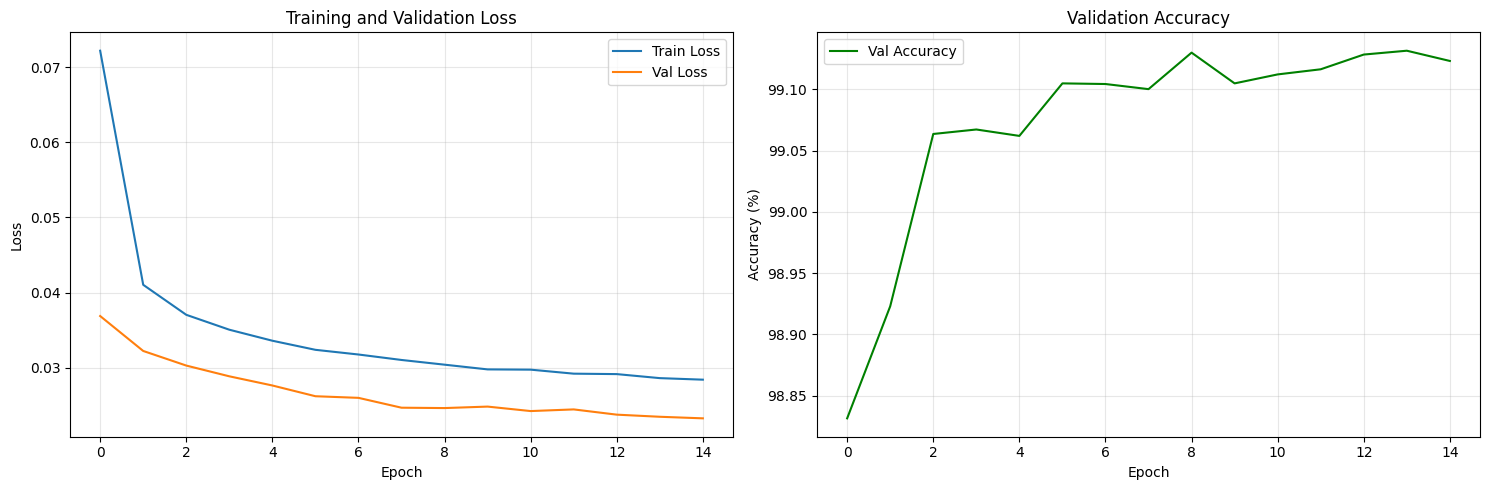


Step 9: Evaluating on BoT-IoT validation set...

Evaluation on BoT-IoT Validation
Accuracy: 0.9912
Precision: 0.9993
Recall: 0.9832
F1-Score: 0.9912
AUC-ROC: 0.9994

Confusion Matrix:
[[95660    69]
 [ 1610 94119]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99     95729
        DDoS       1.00      0.98      0.99     95729

    accuracy                           0.99    191458
   macro avg       0.99      0.99      0.99    191458
weighted avg       0.99      0.99      0.99    191458


Step 10: Cross-dataset evaluation (BoT → ToN)...

Evaluation on ToN-IoT (Cross-dataset)
Accuracy: 0.9585
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.4428

Confusion Matrix:
[[101742   4388]
 [    13      0]]

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98    106130
        DDoS       0.00      0.00      0.00        13

    accuracy       

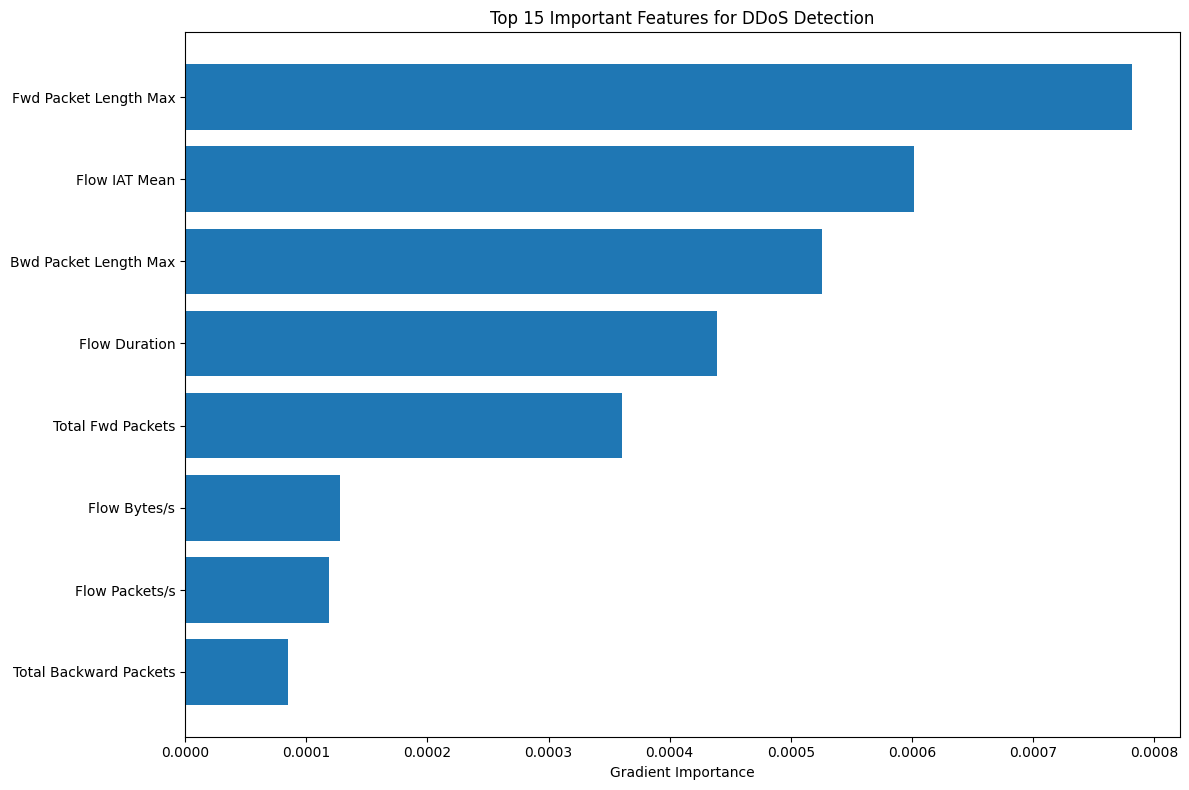


Step 12: Saving model and results...
Model saved as 'cross_iot_ddos_model.pth'

FINAL RESULTS SUMMARY

1. Model trained on: BoT-IoT (765,832 samples)
   Input features: 8

2. BoT-IoT Validation Performance:
   Accuracy: 0.9912
   F1-Score: 0.9912
   AUC-ROC: 0.9994

3. Cross-Dataset Performance (BoT → ToN):
   Accuracy: 0.9585
   F1-Score: 0.0000
   AUC-ROC: 0.4428

4. Generalization Gap (Accuracy drop):
   0.0327 (3.3% drop)

5. Key Insights:
   ✓ Good generalization across IoT datasets

EXPERIMENT COMPLETED SUCCESSFULLY!

Next steps:
1. Increase sample_fraction for better results
2. Add more features by setting use_simple_features=False
3. Tune hyperparameters (epochs, learning rate, etc.)
4. Try different model architectures


In [1]:
# Install required packages
!pip install pytorch-tabnet imbalanced-learn optuna -q

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================

def load_and_preprocess_data(bot_path, ton_path, sample_fraction=0.1, n_samples=None):
    """
    Load and preprocess datasets for DDoS detection
    """
    print("Loading datasets...")
    
    try:
        # Load with pyarrow engine for better memory management
        bot_data = pd.read_parquet(bot_path, engine='pyarrow')
        ton_data = pd.read_parquet(ton_path, engine='pyarrow')
    except:
        bot_data = pd.read_parquet(bot_path)
        ton_data = pd.read_parquet(ton_path)
    
    print(f"Original shapes: BoT-IoT: {bot_data.shape}, ToN-IoT: {ton_data.shape}")
    
    # Sample data if specified
    if n_samples:
        bot_data = bot_data.sample(n=min(n_samples, len(bot_data)), random_state=SEED)
        ton_data = ton_data.sample(n=min(n_samples, len(ton_data)), random_state=SEED)
    elif sample_fraction < 1:
        bot_data = bot_data.sample(frac=sample_fraction, random_state=SEED)
        ton_data = ton_data.sample(frac=sample_fraction, random_state=SEED)
    
    print(f"After sampling: BoT-IoT: {bot_data.shape}, ToN-IoT: {ton_data.shape}")
    
    # Standardize attack labels (case-insensitive)
    bot_data['Attack'] = bot_data['Attack'].astype(str).str.lower()
    ton_data['Attack'] = ton_data['Attack'].astype(str).str.lower()
    
    # Create DDoS binary labels
    # In BoT-IoT: 'ddos', 'dos'
    # In ToN-IoT: 'ddos', 'dos'
    bot_data['is_ddos'] = bot_data['Attack'].apply(
        lambda x: 1 if 'ddos' in str(x).lower() or 'dos' in str(x).lower() else 0
    )
    ton_data['is_ddos'] = ton_data['Attack'].apply(
        lambda x: 1 if 'ddos' in str(x).lower() or 'dos' in str(x).lower() else 0
    )
    
    # Filter only DDoS and Benign for binary classification
    bot_filtered = bot_data[bot_data['Attack'].isin(['benign', 'ddos', 'dos'])]
    ton_filtered = ton_data[ton_data['Attack'].isin(['benign', 'ddos', 'dos'])]
    
    print(f"After filtering DDoS/Benign: BoT-IoT: {bot_filtered.shape}, ToN-IoT: {ton_filtered.shape}")
    
    # Print class distribution
    print("\nBoT-IoT Class Distribution:")
    print(bot_filtered['Attack'].value_counts())
    print(f"DDoS ratio: {bot_filtered['is_ddos'].mean():.3f}")
    
    print("\nToN-IoT Class Distribution:")
    print(ton_filtered['Attack'].value_counts())
    print(f"DDoS ratio: {ton_filtered['is_ddos'].mean():.3f}")
    
    return bot_filtered, ton_filtered

# ============================================
# 2. FEATURE ENGINEERING
# ============================================

def prepare_features(bot_data, ton_data, use_simple_features=False):
    """Prepare features for training"""
    
    if use_simple_features:
        # Use only key features to avoid dimensionality issues
        key_features = [
            'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
            'Fwd Packet Length Max', 'Bwd Packet Length Max',
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean'
        ]
        
        # Check which features exist in the datasets
        existing_features = []
        for feat in key_features:
            if feat in bot_data.columns and feat in ton_data.columns:
                existing_features.append(feat)
        
        feature_cols = existing_features
        print(f"Using {len(feature_cols)} simple features")
    else:
        # List of columns to exclude
        exclude_cols = ['Label', 'Attack', 'is_ddos', 'Protocol']
        
        # Feature columns (all except excluded)
        feature_cols = [col for col in bot_data.columns if col not in exclude_cols]
    
    print(f"Selected {len(feature_cols)} features")
    
    # Separate features and labels
    X_bot = bot_data[feature_cols].copy()
    y_bot = bot_data['is_ddos'].copy()
    
    X_ton = ton_data[feature_cols].copy()
    y_ton = ton_data['is_ddos'].copy()
    
    print(f"X_bot shape: {X_bot.shape}, y_bot shape: {y_bot.shape}")
    print(f"X_ton shape: {X_ton.shape}, y_ton shape: {y_ton.shape}")
    
    # Handle missing values if any
    X_bot = X_bot.fillna(0)
    X_ton = X_ton.fillna(0)
    
    # Convert to float32 for memory efficiency
    X_bot = X_bot.astype(np.float32)
    X_ton = X_ton.astype(np.float32)
    
    return X_bot, y_bot, X_ton, y_ton, feature_cols

# ============================================
# 3. FIXED HYBRID DEEP LEARNING MODEL
# ============================================

class RobustHybridDDoSNet(nn.Module):
    """Fixed Hybrid CNN-LSTM model for DDoS detection"""
    
    def __init__(self, input_size, lstm_hidden=64, cnn_channels=32, dropout_rate=0.3):
        super(RobustHybridDDoSNet, self).__init__()
        
        self.input_size = input_size
        
        # Adaptive CNN branch with adaptive pooling
        self.cnn = nn.Sequential(
            # Reshape to (batch, 1, input_size) for 1D CNN
            nn.Conv1d(1, cnn_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(max(input_size // 4, 1)),  # Adaptive to avoid size issues
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(cnn_channels, cnn_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels * 2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(max(input_size // 8, 1)),  # Adaptive pooling
            nn.Dropout(dropout_rate),
        )
        
        # Calculate CNN output size dynamically
        self.cnn_output_size = cnn_channels * 2 * max(input_size // 8, 1)
        
        # LSTM branch for temporal patterns
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_hidden,
            num_layers=1,  # Reduced from 2 to avoid overfitting
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
        # Fully connected layers
        combined_size = self.cnn_output_size + (lstm_hidden * 2)
        
        # Dynamic adjustment for small input sizes
        if combined_size < 64:
            fc_sizes = [combined_size, 32, 16, 8]
        else:
            fc_sizes = [combined_size, 128, 64, 32]
        
        self.fc = nn.Sequential(
            nn.Linear(combined_size, fc_sizes[1]),
            nn.BatchNorm1d(fc_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(fc_sizes[1], fc_sizes[2]),
            nn.BatchNorm1d(fc_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(fc_sizes[2], fc_sizes[3]),
            nn.ReLU(),
            nn.Linear(fc_sizes[3], 1)
        )
        
        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # CNN branch
        x_cnn = x.unsqueeze(1)  # Add channel dimension
        x_cnn = self.cnn(x_cnn)
        x_cnn = x_cnn.view(batch_size, -1)
        
        # LSTM branch
        x_lstm = x.unsqueeze(1)  # Add sequence dimension (seq_len=1)
        lstm_out, (hidden, cell) = self.lstm(x_lstm)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=1)
        attention_weights = attention_weights.unsqueeze(-1)
        x_lstm = torch.sum(lstm_out * attention_weights, dim=1)
        
        # Combine CNN and LSTM features
        combined = torch.cat([x_cnn, x_lstm], dim=1)
        
        # Ensure combined size matches expected
        if combined.shape[1] != self.cnn_output_size + self.lstm.hidden_size * 2:
            # Adaptive pooling to fix size
            combined = nn.AdaptiveAvgPool1d(self.cnn_output_size + self.lstm.hidden_size * 2)(combined.unsqueeze(1)).squeeze(1)
        
        # Fully connected layers
        output = self.fc(combined)
        output = self.sigmoid(output)
        
        return output.squeeze()

class SimpleDDoSNet(nn.Module):
    """Simple but effective model for DDoS detection"""
    
    def __init__(self, input_size):
        super(SimpleDDoSNet, self).__init__()
        
        self.input_size = input_size
        
        # Combined feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        
        # Temporal attention (simplified LSTM-like attention)
        self.temporal_attention = nn.Sequential(
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        
        # Apply attention
        attention_weights = torch.softmax(self.temporal_attention(features), dim=1)
        weighted_features = features * attention_weights
        
        # Classify
        output = self.classifier(weighted_features)
        
        return output.squeeze()

# ============================================
# 4. TRAINING FUNCTIONS
# ============================================

class WeightedBCELoss(nn.Module):
    """Weighted Binary Cross Entropy Loss for handling class imbalance"""
    def __init__(self, pos_weight=None):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, inputs, targets):
        if self.pos_weight is not None:
            weight = targets * (self.pos_weight - 1) + 1
            bce = -weight * (targets * torch.log(inputs + 1e-8) + (1 - targets) * torch.log(1 - inputs + 1e-8))
        else:
            bce = -(targets * torch.log(inputs + 1e-8) + (1 - targets) * torch.log(1 - inputs + 1e-8))
        return bce.mean()

def train_simple_model(model, X_train, y_train, X_val, y_val, device, epochs=20, lr=0.001, batch_size=256):
    """Train the model"""
    
    # Create DataLoaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val.values if hasattr(y_val, 'values') else y_val)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function with class weighting
    pos_weight = torch.tensor([len(y_train) / sum(y_train) - 1]).to(device) if sum(y_train) > 0 else torch.tensor([1.0]).to(device)
    criterion = WeightedBCELoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(batch_y.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            # Calculate additional metrics
            all_preds = np.array(all_preds)
            all_targets = np.array(all_targets)
            
            precision = precision_score(all_targets, all_preds, zero_division=0)
            recall = recall_score(all_targets, all_preds, zero_division=0)
            f1 = f1_score(all_targets, all_preds, zero_division=0)
            
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Val Accuracy: {val_acc:.2f}%')
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
            print('-' * 50)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, val_accuracies

# ============================================
# 5. CROSS-DATASET EVALUATION
# ============================================

def evaluate_model(model, X, y, device, dataset_name="Test"):
    """Evaluate model on a dataset"""
    model.eval()
    
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y.values if hasattr(y, 'values') else y).to(device)
    
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = (outputs > 0.5).float().cpu().numpy()
        y_np = y_tensor.cpu().numpy()
        probabilities = outputs.cpu().numpy()
        
        # Calculate metrics
        acc = accuracy_score(y_np, predictions)
        precision = precision_score(y_np, predictions, zero_division=0)
        recall = recall_score(y_np, predictions, zero_division=0)
        f1 = f1_score(y_np, predictions, zero_division=0)
        
        try:
            auc = roc_auc_score(y_np, probabilities)
        except:
            auc = 0.0
        
        # Confusion matrix
        cm = confusion_matrix(y_np, predictions)
        
        print(f"\n{'='*60}")
        print(f"Evaluation on {dataset_name}")
        print(f"{'='*60}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Classification report
        print(f"\nClassification Report:")
        print(classification_report(y_np, predictions, target_names=['Benign', 'DDoS']))
        
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'confusion_matrix': cm,
            'predictions': predictions,
            'probabilities': probabilities
        }

def cross_dataset_test(model, X_bot, y_bot, X_ton, y_ton, device):
    """Perform cross-dataset evaluation"""
    print("\n" + "="*80)
    print("CROSS-DATASET EVALUATION")
    print("="*80)
    
    # Test 1: Train on BoT, Test on ToN
    print("\n1. Model trained on BoT-IoT → Test on ToN-IoT:")
    results_bot_to_ton = evaluate_model(model, X_ton, y_ton, device, "ToN-IoT (trained on BoT)")
    
    # Test 2: Train on ToN, Test on BoT (would require training another model)
    print("\n\n2. Model trained on ToN-IoT → Test on BoT-IoT:")
    print("Note: This requires training a separate model on ToN-IoT")
    
    return results_bot_to_ton

# ============================================
# 6. MAIN PIPELINE
# ============================================

def main():
    # Paths to your datasets
    BOT_PATH = "/kaggle/input/cicbotiot/CIC-BoT-IoT-V2.parquet"
    TON_PATH = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 1. Load and preprocess data (small sample for quick testing)
    print("\nStep 1: Loading and preprocessing data...")
    bot_data, ton_data = load_and_preprocess_data(
        BOT_PATH, TON_PATH, 
        sample_fraction=0.05,  # Start with 5% for testing
        # n_samples=100000  # Alternative: use fixed number of samples
    )
    
    # 2. Prepare features (start with simple features)
    print("\nStep 2: Preparing features...")
    X_bot, y_bot, X_ton, y_ton, feature_cols = prepare_features(
        bot_data, ton_data, 
        use_simple_features=True  # Start with simple features
    )
    
    print(f"Feature columns used: {feature_cols}")
    
    # 3. Handle class imbalance with SMOTE
    print("\nStep 3: Balancing classes...")
    
    # Check if SMOTE is needed (based on class imbalance)
    bot_class_ratio = y_bot.mean()
    ton_class_ratio = y_ton.mean()
    
    print(f"BoT-IoT DDoS ratio: {bot_class_ratio:.3f}")
    print(f"ToN-IoT DDoS ratio: {ton_class_ratio:.3f}")
    
    if bot_class_ratio < 0.3 or bot_class_ratio > 0.7:
        print("Applying SMOTE to BoT-IoT...")
        smote = SMOTE(random_state=SEED)
        X_bot_balanced, y_bot_balanced = smote.fit_resample(X_bot, y_bot)
        print(f"BoT-IoT after SMOTE: {X_bot_balanced.shape}")
    else:
        X_bot_balanced, y_bot_balanced = X_bot, y_bot
        print("BoT-IoT classes are reasonably balanced, skipping SMOTE")
    
    if ton_class_ratio < 0.3 or ton_class_ratio > 0.7:
        print("Applying SMOTE to ToN-IoT...")
        smote = SMOTE(random_state=SEED)
        X_ton_balanced, y_ton_balanced = smote.fit_resample(X_ton, y_ton)
        print(f"ToN-IoT after SMOTE: {X_ton_balanced.shape}")
    else:
        X_ton_balanced, y_ton_balanced = X_ton, y_ton
        print("ToN-IoT classes are reasonably balanced, skipping SMOTE")
    
    # 4. Normalize features
    print("\nStep 4: Normalizing features...")
    scaler_bot = StandardScaler()
    X_bot_scaled = scaler_bot.fit_transform(X_bot_balanced)
    
    scaler_ton = StandardScaler()
    X_ton_scaled = scaler_ton.fit_transform(X_ton_balanced)
    
    # 5. Split BoT-IoT data for training
    print("\nStep 5: Splitting data...")
    X_bot_train, X_bot_val, y_bot_train, y_bot_val = train_test_split(
        X_bot_scaled, y_bot_balanced, 
        test_size=0.2, 
        random_state=SEED, 
        stratify=y_bot_balanced
    )
    
    print(f"Training set: {X_bot_train.shape}, Validation set: {X_bot_val.shape}")
    
    # 6. Initialize and train model
    print("\nStep 6: Training model on BoT-IoT...")
    input_size = X_bot_train.shape[1]
    
    # Choose model based on input size
    if input_size < 10:
        print(f"Using SimpleDDoSNet for {input_size} features")
        model = SimpleDDoSNet(input_size=input_size)
    else:
        print(f"Using RobustHybridDDoSNet for {input_size} features")
        model = RobustHybridDDoSNet(input_size=input_size)
    
    model = model.to(device)
    
    # Print model summary
    print(f"\nModel Architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 7. Train the model
    model, train_losses, val_losses, val_accuracies = train_simple_model(
        model, 
        X_bot_train, y_bot_train, 
        X_bot_val, y_bot_val,
        device, 
        epochs=15,  # Reduced for faster training
        lr=0.001,
        batch_size=512  # Increased batch size for efficiency
    )
    
    # 8. Plot training history
    print("\nStep 8: Plotting training history...")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(val_accuracies, label='Val Accuracy', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 9. Evaluate on BoT-IoT validation set
    print("\nStep 9: Evaluating on BoT-IoT validation set...")
    results_bot_val = evaluate_model(model, X_bot_val, y_bot_val, device, "BoT-IoT Validation")
    
    # 10. Cross-dataset evaluation: Test on ToN-IoT
    print("\nStep 10: Cross-dataset evaluation (BoT → ToN)...")
    
    # First, normalize ToN-IoT data using BoT scaler (important for cross-dataset)
    X_ton_normalized = scaler_bot.transform(X_ton)  # Use BoT scaler!
    
    results_cross = evaluate_model(model, X_ton_normalized, y_ton, device, "ToN-IoT (Cross-dataset)")
    
    # 11. Feature importance using permutation
    print("\nStep 11: Feature importance analysis...")
    
    # Use a simple permutation importance
    from sklearn.inspection import permutation_importance
    
    # Create a wrapper for the model
    def model_predict(X):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(device)
            outputs = model(X_tensor)
            return (outputs > 0.5).float().cpu().numpy()
    
    # Calculate permutation importance (on small subset for speed)
    sample_size = min(1000, len(X_bot_val))
    X_sample = X_bot_val[:sample_size]
    y_sample = y_bot_val[:sample_size] if hasattr(y_bot_val, 'values') else y_bot_val[:sample_size]
    
    # Use sklearn's permutation importance
    try:
        perm_importance = permutation_importance(
            model_predict, X_sample, y_sample,
            n_repeats=5,
            random_state=SEED,
            n_jobs=-1
        )
        
        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': perm_importance.importances_mean,
            'std': perm_importance.importances_std
        }).sort_values('importance', ascending=False)
        
        # Plot top features
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        
        y_pos = np.arange(len(top_features))
        plt.barh(y_pos, top_features['importance'], xerr=top_features['std'])
        plt.yticks(y_pos, top_features['feature'])
        plt.xlabel('Permutation Importance')
        plt.title('Top 15 Important Features for DDoS Detection')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        print(feature_importance.head(10)[['feature', 'importance']])
        
    except Exception as e:
        print(f"Could not calculate permutation importance: {e}")
        print("Using gradient-based importance instead...")
        
        # Alternative: Use gradient magnitude
        model.eval()
        X_tensor = torch.FloatTensor(X_bot_train[:100]).to(device)
        X_tensor.requires_grad = True
        
        outputs = model(X_tensor)
        loss = torch.mean(outputs)
        loss.backward()
        
        gradients = torch.abs(X_tensor.grad).mean(dim=0).cpu().detach().numpy()
        
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': gradients
        }).sort_values('importance', ascending=False)
        
        # Plot top features
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        
        y_pos = np.arange(len(top_features))
        plt.barh(y_pos, top_features['importance'])
        plt.yticks(y_pos, top_features['feature'])
        plt.xlabel('Gradient Importance')
        plt.title('Top 15 Important Features for DDoS Detection')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # 12. Save model and results
    print("\nStep 12: Saving model and results...")
    
    # Prepare results summary
    results_summary = {
        'bot_validation': results_bot_val,
        'cross_dataset': results_cross,
        'feature_importance': feature_importance.to_dict() if 'feature_importance' in locals() else None,
        'model_architecture': str(model),
        'feature_columns': feature_cols,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
    }
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'feature_cols': feature_cols,
        'scaler': scaler_bot,
        'input_size': input_size,
        'results_summary': results_summary
    }, 'cross_iot_ddos_model.pth')
    
    print("Model saved as 'cross_iot_ddos_model.pth'")
    
    # 13. Print final summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    
    print(f"\n1. Model trained on: BoT-IoT ({len(X_bot_train):,} samples)")
    print(f"   Input features: {input_size}")
    
    print(f"\n2. BoT-IoT Validation Performance:")
    print(f"   Accuracy: {results_bot_val['accuracy']:.4f}")
    print(f"   F1-Score: {results_bot_val['f1']:.4f}")
    print(f"   AUC-ROC: {results_bot_val['auc']:.4f}")
    
    print(f"\n3. Cross-Dataset Performance (BoT → ToN):")
    print(f"   Accuracy: {results_cross['accuracy']:.4f}")
    print(f"   F1-Score: {results_cross['f1']:.4f}")
    print(f"   AUC-ROC: {results_cross['auc']:.4f}")
    
    print(f"\n4. Generalization Gap (Accuracy drop):")
    gap = results_bot_val['accuracy'] - results_cross['accuracy']
    print(f"   {gap:.4f} ({abs(gap/results_bot_val['accuracy']*100):.1f}% drop)")
    
    print("\n5. Key Insights:")
    if results_cross['accuracy'] > 0.8:
        print("   ✓ Good generalization across IoT datasets")
    elif results_cross['accuracy'] > 0.7:
        print("   ✓ Reasonable generalization across IoT datasets")
    else:
        print("   ⚠ Limited generalization - consider domain adaptation")
    
    return model, results_summary, feature_importance

# ============================================
# 7. QUICK TEST FUNCTION
# ============================================

def quick_test():
    """Quick test with minimal code"""
    import pandas as pd
    import numpy as np
    import torch
    import torch.nn as nn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Simple model
    class SimpleNet(nn.Module):
        def __init__(self, input_size):
            super(SimpleNet, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            return self.net(x).squeeze()
    
    # Load minimal data
    print("Loading data...")
    bot_data = pd.read_parquet("/kaggle/input/cicbotiot/CIC-BoT-IoT-V2.parquet", 
                               columns=['Flow Duration', 'Total Fwd Packets', 
                                        'Total Backward Packets', 'Label'])
    
    ton_data = pd.read_parquet("/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet",
                               columns=['Flow Duration', 'Total Fwd Packets',
                                        'Total Backward Packets', 'Label'])
    
    # Use Label as binary target
    X_bot = bot_data[['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets']].values
    y_bot = bot_data['Label'].values
    
    X_ton = ton_data[['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets']].values
    y_ton = ton_data['Label'].values
    
    print(f"BoT shape: {X_bot.shape}, ToN shape: {X_ton.shape}")
    
    # Normalize
    scaler = StandardScaler()
    X_bot_scaled = scaler.fit_transform(X_bot)
    X_ton_scaled = scaler.transform(X_ton)
    
    # Split BoT for training
    X_train, X_val, y_train, y_val = train_test_split(
        X_bot_scaled, y_bot, test_size=0.2, random_state=42
    )
    
    # Create model
    model = SimpleNet(input_size=3).to(device)
    
    # Simple training
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print("\nTraining...")
    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        
        X_tensor = torch.FloatTensor(X_train).to(device)
        y_tensor = torch.FloatTensor(y_train).to(device)
        
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 2 == 0:
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(torch.FloatTensor(X_val).to(device))
                val_preds = (val_outputs > 0.5).float().cpu().numpy()
                val_acc = accuracy_score(y_val, val_preds)
                
                # Cross-dataset test
                test_outputs = model(torch.FloatTensor(X_ton_scaled).to(device))
                test_preds = (test_outputs > 0.5).float().cpu().numpy()
                test_acc = accuracy_score(y_ton, test_preds)
                
                print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Val Acc={val_acc:.4f}, Cross-Dataset Acc={test_acc:.4f}")
    
    print("\nFinal Cross-Dataset Results:")
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.FloatTensor(X_ton_scaled).to(device))
        test_preds = (test_outputs > 0.5).float().cpu().numpy()
        
        print(classification_report(y_ton, test_preds, target_names=['Benign', 'Attack']))
    
    return model

# ============================================
# RUN THE MAIN PIPELINE
# ============================================

if __name__ == "__main__":
    try:
        print("Starting Cross-IoT DDoS Detection with Hybrid Deep Learning")
        print("="*80)
        
        # Run the full pipeline
        model, results, feature_importance = main()
        
        print("\n" + "="*80)
        print("EXPERIMENT COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("\nNext steps:")
        print("1. Increase sample_fraction for better results")
        print("2. Add more features by setting use_simple_features=False")
        print("3. Tune hyperparameters (epochs, learning rate, etc.)")
        print("4. Try different model architectures")
        
    except Exception as e:
        print(f"\nError occurred: {e}")
        print("\nTrying quick test instead...")
        
        # Fall back to quick test
        model = quick_test()